In [1]:
import torch, pickle, argparse
import numpy as np, pytorch_lightning as pl, matplotlib.pyplot as plt, eagerpy as ep
from old_S2CNN_model import S2ConvNet
from data_loader import load_train_data, load_test_data
from foolbox import PyTorchModel, accuracy, samples
from attacks import RandomLInfStep
from tqdm.notebook import tqdm

In [2]:
filename = 'S2CNN_first_tests_smaller_training_sets.pickle'

with open(filename, 'rb') as file:
    loaded = pickle.load(file)
    
data = np.array(loaded)
hparams = argparse.Namespace(**data[1][1][1])

In [3]:
TEST_PATH = "s2_mnist.gz"
TRAIN_PATH = "s2_mnist_train_dwr_10000.gz"

train_data = load_train_data(TRAIN_PATH)
test_data = load_test_data(TEST_PATH)

In [4]:
model = S2ConvNet(hparams, train_data, test_data).eval()
trainer = pl.Trainer(gpus=1, logger=False)
best_model = torch.load('checkpoints/epoch=17_v14.ckpt')
model.load_state_dict(best_model['state_dict'])

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


<All keys matched successfully>

In [5]:
fmodel = PyTorchModel(model, bounds=(0, 255))

images = test_data[:][0].cuda()
labels = test_data[:][1].cuda()
images = ep.astensor(images)
labels = ep.astensor(labels)

In [6]:
attack = RandomLInfStep()
epsilons = [0.1, 0.5, 1, 5, 10, 20, 30, 50, 80, 100]

In [7]:
bs = 25
with tqdm(total=10000//bs) as pbar:
    raw_advs, clipped_advs, success = attack(fmodel, images[:bs], labels[:bs], epsilons=epsilons)
    pbar.update(1)

    for i in range(1,10000//bs):
        dummy_raw_advs, dummy_clipped_advs, dummy_success = attack(fmodel, images[bs*i:bs*(i+1)], labels[bs*i:bs*(i+1)], epsilons=epsilons)

        for j in range(10):
            raw_advs[j] = ep.concatenate((raw_advs[j], dummy_raw_advs[j]), axis=0)
            clipped_advs[j] = ep.concatenate((clipped_advs[j], dummy_clipped_advs[j]), axis=0)
        success = ep.concatenate((success, dummy_success), axis=1)
        pbar.update(1)

  0%|          | 0/400 [00:00<?, ?it/s]

load 0.pkl.gz... done
load 2.pkl.gz... done
load 1.pkl.gz... done
load 2.pkl.gz... done
load 8.pkl.gz... done
load 3.pkl.gz... done
load 4.pkl.gz... done
load 9.pkl.gz... done
load 14.pkl.gz... done
load 10.pkl.gz... done
load 15.pkl.gz... done
load 16.pkl.gz... done
load 11.pkl.gz... done
load 17.pkl.gz... done
load 12.pkl.gz... done
load 18.pkl.gz... done
load 19.pkl.gz... done
load 13.pkl.gz... done
load 20.pkl.gz... done


In [8]:
clean_accuracy = []
for i in tqdm(range(10000//bs)):
    clean_accuracy.append(accuracy(fmodel, images[bs*i:bs*(i+1)], labels[bs*i:bs*(i+1)]))

clean_accuracy = np.mean(clean_accuracy)

  0%|          | 0/400 [00:00<?, ?it/s]

In [9]:
success_rate = success.float32().mean(axis=-1)

robust_accuracy = 1 - success_rate
print("robust accuracy for perturbations with")
for eps, acc in zip(epsilons, robust_accuracy):
    print(f"  Linf norm ≤ {eps:<6}: {acc.item() * 100:4.1f} %")

robust accuracy for perturbations with
  Linf norm ≤ 0.1   : 97.8 %
  Linf norm ≤ 0.5   : 97.9 %
  Linf norm ≤ 1     : 97.7 %
  Linf norm ≤ 5     : 96.6 %
  Linf norm ≤ 10    : 89.9 %
  Linf norm ≤ 20    : 61.0 %
  Linf norm ≤ 30    : 48.6 %
  Linf norm ≤ 50    : 29.9 %
  Linf norm ≤ 80    : 10.3 %
  Linf norm ≤ 100   : 10.1 %


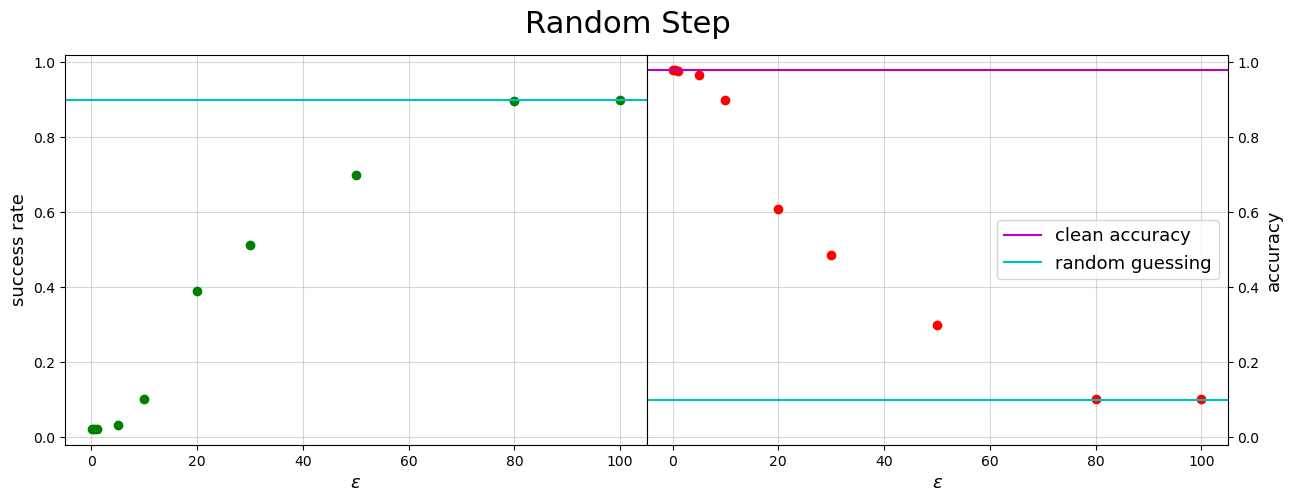

In [10]:
fontsize = 13

fig, axs = plt.subplots(nrows=1, ncols=2, figsize = (15, 5), gridspec_kw = {'wspace':0., 'hspace':0.})
fig.suptitle('Random Step', fontsize=22)
plt.subplots_adjust(top=0.89)
axs[0].plot(epsilons, success_rate.raw.cpu(), 'og')
axs[0].set_ylabel('success rate', fontsize=fontsize)
axs[0].axhline(y=0.9, color='c')
axs[1].plot(epsilons, robust_accuracy.raw.cpu(), 'or')
# axs[1].plot(epsilons, post_acc, 'ob')
axs[1].axhline(y=clean_accuracy, color='m', label='clean accuracy')
axs[1].yaxis.set_label_position("right")
axs[1].yaxis.tick_right()
axs[1].set_ylabel('accuracy', fontsize=fontsize)
axs[1].axhline(y=0.1, color='c', label='random guessing')
for j in range(2):
    axs[j].set_xlabel(r'$\epsilon$', fontsize=fontsize)
    axs[j].set_ylim([-0.02,1.02])
    axs[j].grid(alpha=0.5)

axs[1].legend(fontsize=fontsize)

plt.show()